In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob
from itertools import product
from functools import partial

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

import pandas as pd
import seaborn as sns

from pathlib import Path
from sbibm.utils.io import get_tensor_from_csv

from notebook import nre_gamma_default, prepare_df_for_plot, get_metrics, figsize, wide_to_long

import numpy as np

In [3]:
linestyles = {2: "dashed", 3: "solid"}
avglogratio_name = r"Mean -$\log \hat{r}_{\mathbf{w}}(\mathbf{x} \mid \mathbf{\theta})$"
validation_loss_name = "$I^(0)$"
legend_title = "Contrastive" + "\n" + "parameters"
alpha=0.7

height = 2.5

def plot_avg_log_ratios(path: pd.Series, num_blocks: pd.Series, **kwargs):
    ax = plt.gca()
    for index in path.index:
        ax.plot(
            -get_tensor_from_csv(Path(path[index]) / "avg_log_ratios.csv"), linestyle=linestyles[num_blocks[index]], 
            alpha=alpha,
            **kwargs
        )
    ax.set_xscale("log")

def plot_validation_loss(path: pd.Series, num_blocks: pd.Series, **kwargs):
    ax = plt.gca()
    for index in path.index:
        ax.plot(
            get_tensor_from_csv(Path(path[index]) / "validation_loss.csv"), 
            linestyle=linestyles[num_blocks[index]], 
            alpha=alpha,
            **kwargs
        )
    ax.set_xscale("log")

    
def get_first_of_group(df: pd.DataFrame) -> pd.DataFrame:
    grp = df.groupby(["task", "algorithm", "gamma", "num_blocks", "num_contrastive_parameters"])
    return grp.first().reset_index()

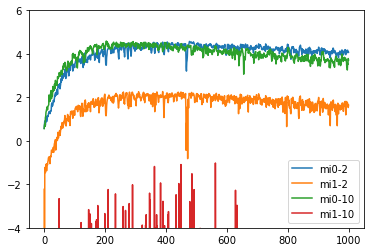

In [4]:
roots = [
    "/home/ben/sci/cnre/infinite/outputs/2022-06-09/16-01-25/",
    "/home/ben/sci/cnre/infinite/outputs/2022-06-09/16-07-20/",
]
ks = [2, 10]

fig, ax = plt.subplots()

for root, k in zip(roots, ks):
    p0 = root + "path_mutual_information_0s.csv"
    p1 = root + "path_mutual_information_1s.csv"
    ax.plot(get_tensor_from_csv(p0), label=f"mi0-{k}")
    ax.plot(get_tensor_from_csv(p1), label=f"mi1-{k}")
    ax.set_ylim(-4.0, 6.0)
ax.legend()

In [5]:
linestyles = {2: "dashed", 3: "solid"}
# avglogratio_name = r"Mean -$\log \hat{r}_{\mathbf{w}}(\mathbf{x} \mid \mathbf{\theta})$"
# validation_loss_name = "Mean validation loss"
# legend_title = "Contrastive" + "\n" + "parameters"
# alpha=0.7

# height = 2.5



# def plot_avg_log_ratios(path: pd.Series, num_blocks: pd.Series, **kwargs):
#     ax = plt.gca()
#     for index in path.index:
#         ax.plot(
#             -get_tensor_from_csv(Path(path[index]) / "avg_log_ratios.csv"), linestyle=linestyles[num_blocks[index]], 
#             alpha=alpha,
#             **kwargs
#         )
#     ax.set_xscale("log")

    
# def plot_validation_loss(path: pd.Series, num_blocks: pd.Series, **kwargs):
#     ax = plt.gca()
#     for index in path.index:
#         ax.plot(
#             get_tensor_from_csv(Path(path[index]) / "validation_loss.csv"), 
#             linestyle=linestyles[num_blocks[index]], 
#             alpha=alpha,
#             **kwargs
#         )
#     ax.set_xscale("log")

    
# def get_first_of_group(df: pd.DataFrame) -> pd.DataFrame:
#     grp = df.groupby(["task", "algorithm", "gamma", "num_blocks", "num_contrastive_parameters"])
#     return grp.first().reset_index()


def plot_either_val_or_avglogratio_or_mi(path: pd.Series, metric: pd.Series, num_blocks: pd.Series, **kwargs):
    ax = plt.gca()
    for index in path.index:
        if metric[index] == "validation":
            time_series = get_tensor_from_csv(Path(path[index]) / "validation_loss.csv")
            yscale = "log"
        elif metric[index] == "avglogratio":
            time_series = -get_tensor_from_csv(Path(path[index]) / "avg_log_ratios.csv")
            # yscale = "symlog"
            yscale = "linear"
        elif metric[index] == "mi0":
            time_series = -get_tensor_from_csv(Path(path[index]) / "mutual_information_0s.csv")
            yscale = "linear"
            # yscale = "symlog"
        elif metric[index] == "mi1":
            time_series = -get_tensor_from_csv(Path(path[index]) / "mutual_information_1s.csv")
            yscale = "linear"
        else:
            raise NotImplementedError(metric[index])
        ax.plot(time_series, linestyle=linestyles[num_blocks[index]], alpha=alpha, **kwargs)
    ax.set_xscale("log")
    ax.set_yscale(yscale)

In [6]:
df = get_metrics(
    [
        "mi.csv",
    ],
    "mi",
)
df["gamma"] = df["gamma"].fillna(nre_gamma_default)

dict_keys([('mi0', 0.001), ('mi0', 0.01), ('mi0', 0.1), ('mi0', 1.0), ('mi0', 10.0), ('mi0', 100.0)])


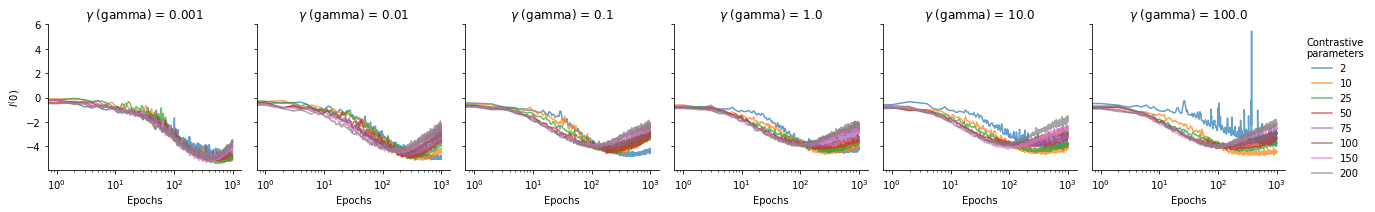

In [7]:
df_sameval = df[
    (df["algorithm"] == "CNRE")
    # (df["algorithm"] == "NRE-B")
    & (df["task"] == "slcp")
    & (df["num_blocks"] == 3)
].copy()

# df_sameval_copy = df_sameval.copy()
# df_sameval_copy["metric"] = "avglogratio"

df_sameval["metric"] = "mi0"

# df_sameval = pd.concat([df_sameval, df_sameval_copy], ignore_index=True)
grp = df_sameval.groupby(["task", "algorithm", "gamma", "num_blocks", "num_contrastive_parameters", "metric"])
df_sameval = grp.first().reset_index()

g = sns.FacetGrid(
    df_sameval, 
    # x="path",  #to look up series
    hue="num_contrastive_parameters",
    row="metric",
    col="gamma", 
    height=3,
    sharey="row",
    # legend_out=True,
    legend_out=False
)

g.figure.tight_layout()
g.map(plot_either_val_or_avglogratio_or_mi, "path", "metric", "num_blocks")

g.add_legend()
sns.move_legend(g, "center left", bbox_to_anchor=(1.0, 0.5), frameon=False)
g.legend.set_title(legend_title)

print(g.axes_dict.keys())
# ax = g.axes_dict[('avglogratio', 0.001)]
# ax.set_ylabel(avglogratio_name)

ax = g.axes_dict[('mi0', 0.001)]
ax.set_ylabel(validation_loss_name)

for ax in g.axes[0, :]:
    value = ax.get_title().split()[-1]
    ax.set_title(fr"$\gamma$ (gamma) = {value}")
    ax.set_xlabel("Epochs")

## compare to c2st

In [8]:
df_wide, grp = wide_to_long(df)

In [22]:
df_preped = df_wide.reset_index()
df_preped["min_mi0"] = df_preped["path"].map(lambda x: -get_tensor_from_csv(Path(x) / "mutual_information_0s.csv").min().numpy())

cols = ["num_contrastive_parameters", "gamma", "C2ST_Z"]

df_c2st = grp.aggregate({"C2ST_Z": ["mean"], 
                         # "path": ["first"]
                        }).reset_index()
print(df_c2st[cols].groupby(["gamma", "num_contrastive_parameters"]).first())

                                      C2ST_Z
                                        mean
gamma   num_contrastive_parameters          
0.001   2                           0.837395
        10                          0.828675
        25                          0.837655
        50                          0.815100
        75                          0.835250
        100                         0.826730
        150                         0.821595
        200                         0.843055
0.010   2                           0.814255
        10                          0.811725
        25                          0.848465
        50                          0.846310
        75                          0.858185
        100                         0.867920
        150                         0.876750
        200                         0.868615
0.100   2                           0.849330
        10                          0.852525
        25                          0.866045
        50

/tmp/ipykernel_144799/2165468803.py:9: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  print(df_c2st[cols].groupby(["gamma", "num_contrastive_parameters"]).first())


In [21]:
grp.first().columns

Index(['RT', 'expr', 'reuse', 'MMD-07', 'NLTP-07', 'NLTP-10', 'MEDDIST-01',
       'extra_theta_factor', 'MEDDIST-02', 'num_atoms', 'NLTP-09', 'NLTP-01',
       'MMD-09', 'MEDDIST-07', 'MMD-08', 'NLTP-04', 'MMD-04', 'MMD-10',
       'num_simulations_simulator', 'folder', 'MEDDIST-03', 'NLTP-02',
       'MMD-03', 'NLTP-05', 'MMD-05', 'MEDDIST-06', 'MMD-02', 'MEDDIST-05',
       'AVG_LOG_RATIO', 'MMD-01', 'NLTP-06', 'NLTP-03', 'K', 'MEDDIST-08',
       'NLTP', 'MEDDIST-09', 'MEDDIST-04', 'MMD-06', 'NLTP-08', 'MEDDIST-10',
       'C2ST_Z'],
      dtype='object')